In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive
import time
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -R '/content/texts'

rm: cannot remove '/content/texts': No such file or directory


In [ ]:
!unzip -q '/content/drive/MyDrive/Lessons/Lesson4/Тексты писателей.zip' -d '/content/texts'

In [ ]:
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  text = text.replace("\n", " ")
  
  return text         

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"]
nClasses = len(className)

In [ ]:
trainText = []
testText = []

for i in className:
  for j in os.listdir('texts/Тексты писателей'):
    if i in j:
      
      if 'Обучающая' in j:  
        trainText.append(readText('texts/Тексты писателей/' + j))
        print(j, 'добавлен в обучающую выборку')
      if 'Тестовая' in j:
        testText.append(readText('texts/Тексты писателей/' + j)) 
        print(j, 'добавлен в тестовую выборку')
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



In [ ]:
print(len(trainText))
print(len(trainText[0]))

6
1049517


In [ ]:
cur_time = time.time() 
maxWordsCount = 20000 

tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True,
                      split=' ',
                      oov_token='unknown',
                      char_level=False)

tokenizer.fit_on_texts(trainText)
items = list(tokenizer.word_index.items())
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 2.98c


In [ ]:
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

In [ ]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0
wordsTrainText = 0

for i in range(nClasses):
  print(className[i], " "*(10-len(className[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i])
  wordsTrainText += len(trainWordIndexes[i])

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0
wordsTestText = 0

for i in range(nClasses):
  print(className[i], ' '*(10-len(className[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i])
  wordsTestText += len(testWordIndexes[i])
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
О. Генри    1049517 символов,  160607 слов
Стругацкие  2042469 символов,  313012 слов
Булгаков    1765648 символов,  261465 слов
Саймак      1609507 символов,  251502 слов
Фрай        3700010 символов,  568533 слов
Брэдберри   1386454 символов,  214454 слов
----
В сумме  11553605  символов,  1769573  слов 


Статистика по тестовым текстам:
О. Генри    349662 символов,  53238 слов
Стругацкие  704846 символов,  108621 слов
Булгаков    875042 символов,  132730 слов
Саймак      318811 символов,  50360 слов
Фрай        1278191 символов,  196731 слов
Брэдберри   868673 символов,  132524 слов
----
В сумме  4395225  символов,  674204  слов


In [ ]:
# Обработка единиц данных
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
  return xSample

In [ ]:
# Обработка всей базы данных
def createSetsMultiClasses(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))


  xSamples = []
  ySamples = []
  
  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)):
      xSamples.append(xT[i])
      ySamples.append(utils.to_categorical(t, nClasses))

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)

  
  return (xSamples, ySamples)

In [ ]:
# Задаем гиперпараметры для функции
xLen = 1000
step = 100

In [ ]:
cur_time = time.time()

xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)
Время обработки: 2.49c


In [ ]:
cur_time = time.time()

xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())

print(xTrain01.shape)
print(xTrain01[0][0:100])
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 20000)
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1.]
Время обработки: 13.89c


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               4000200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1206      
Total params: 4,002,206
Trainable params: 4,001,806
Non-trainable params: 400
_________________________________________________________________
Epoch 1/10
138/138 [==============================] - 11s 77ms/step - loss: 0.0472 - accuracy: 0.9853 - val_loss: 0.3738 - val_accuracy: 0.8980
Epoch 2/10
138/138 [==============================] - 10s 74ms/step - loss: 3.9888e-04 - accurac

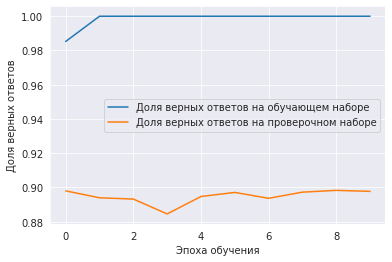

In [ ]:
model01 = Sequential()
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
model01.add(Dropout(0.25))
model01.add(BatchNormalization())
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model01.summary()

history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
def createTestMultiClasses(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  xTest6Classes01 = []
  xTest6Classes = []
  for wI in wordIndexes:
    sample = getSetFromIndexes(wI, xLen, step)
    xTest6Classes.append(sample)
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample))
  xTest6Classes01 = np.array(xTest6Classes01)
  xTest6Classes = np.array(xTest6Classes)
  
  return xTest6Classes01, xTest6Classes


In [ ]:
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print('-'*20)
  
  totalSumRec = 0
  
  for i in range(nClasses):
    currPred = model.predict(xTest[i])

    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal)
    
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ",
        int(100*totalSumRec/sumCount),
        "%",
        sep='')

  print()
  
  return totalSumRec/sumCount

In [ ]:
xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
l = np.array(xTest6Classes01)
np.save('xTestPredictBoW', l)
np.save('xTestPredictEmbedding', x2)

In [ ]:
pred = recognizeMultiClass(model01, xTest6Classes01, "Dense")

НЕЙРОНКА:  Dense
--------------------
Класс: О. Генри   93% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 87% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   76% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     87% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       93% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  98% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 89%

